# 🧠 OASIS – EDA de Cortes Coronales
## Análisis Exploratorio de Datos de Imágenes Coronales MRI

Este notebook realiza un **análisis exploratorio de datos (EDA)** especializado sobre **imágenes coronales** ya procesadas y clasificadas en carpetas por categoría clínica:

- **`CN`** – Cognitively Normal (CDR = 0): Pacientes sin deterioro cognitivo
- **`MCI`** – Mild Cognitive Impairment (CDR = 0.5): Deterioro cognitivo leve
- **`AD`** – Alzheimer (CDR ≥ 1): Enfermedad de Alzheimer

### Estructura de Datos

Las imágenes se encuentran en formato PNG/grayscale en:

```text
data/processed/OASIS_2D/
    CN/    (350 imágenes)
    MCI/   (198 imágenes)
    AD/    (48 imágenes)
```

### Objetivos del Análisis

Este EDA se enfoca en análisis **espaciales y regionales** de las imágenes coronales:

1. **Análisis de intensidades globales**: Distribución general de valores de píxeles por clase
2. **Análisis por secciones (grilla 2D)**: Identificar regiones específicas del cerebro con diferencias entre clases
3. **Perfiles de intensidad**: Análisis unidimensional por columnas y filas para detectar patrones direccionales
4. **Imágenes promedio y mapas de diferencia**: Visualización de cambios voxel a voxel entre clases
5. **PCA espacial**: Reducción de dimensionalidad para explorar separabilidad de clases

### ¿Qué Buscamos Encontrar?

- **Regiones cerebrales afectadas**: ¿Qué áreas del corte coronal muestran más cambios en AD/MCI?
- **Patrones espaciales**: ¿Hay asimetrías o patrones direccionales en los cambios?
- **Biomarcadores regionales**: ¿Qué regiones específicas mejor distinguen entre categorías?
- **Separabilidad de clases**: ¿Las imágenes se agrupan por clase en el espacio de características?


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from sklearn.decomposition import PCA

BASE_DIR = r"C:\\Users\\mmera\\OneDrive\\Escritorio\\ProyectoMineria\\proyectoMineria"
CORONAL_DIR = os.path.join(BASE_DIR, 'data', 'processed', 'OASIS_2D')

classes = ['CN', 'MCI', 'AD']
images_paths = {c: sorted(glob(os.path.join(CORONAL_DIR, c, '*.png'))) for c in classes}

for c in classes:
    print(c, '→', len(images_paths[c]), 'imágenes')

CN → 350 imágenes
MCI → 198 imágenes
AD → 48 imágenes


## 1. Carga de Imágenes en Memoria

### ¿Qué se analiza aquí?

Cargamos una **muestra representativa** de imágenes de cada categoría en memoria para realizar los análisis. Debido a limitaciones de memoria, cargamos un número limitado de imágenes por clase.

### ¿Qué buscamos encontrar?

1. **Disponibilidad de datos**: Verificar que las imágenes estén correctamente organizadas
2. **Balance del dataset**: Evaluar la distribución de imágenes entre categorías
3. **Dimensiones consistentes**: Confirmar que todas las imágenes tienen el mismo tamaño

### ¿Por qué es importante?

- **Gestión de memoria**: Limitar el número de imágenes evita saturar la RAM
- **Análisis representativo**: Una muestra suficiente (ej: 100-200 por clase) permite análisis estadísticamente válidos
- **Validación de datos**: Confirma que el preprocesamiento fue exitoso

### Parámetros importantes:

- **MAX_PER_CLASS**: Número máximo de imágenes a cargar por categoría
  - Valores típicos: 100-200 imágenes
  - Más imágenes = análisis más robusto pero mayor uso de memoria
  - Menos imágenes = análisis más rápido pero menos representativo

### Interpretación esperada:

- **Dimensiones consistentes**: Todas las imágenes deberían tener shape (256, 128) o similar
- **Distribución desbalanceada**: Es normal en datos médicos (más controles que casos)
- **Carga exitosa**: Sin errores al abrir o convertir las imágenes

In [3]:
MAX_PER_CLASS = 200 

def load_images(paths, max_n=None):
    imgs = []
    for p in (paths[:max_n] if max_n else paths):
        img = Image.open(p).convert('L')  # grayscale
        imgs.append(np.array(img, dtype=np.float32))
    return np.stack(imgs, axis=0)  # (N, H, W)

data = {}
for c in classes:
    if len(images_paths[c]) == 0:
        print(f'[WARN] No hay imágenes para {c}')
        data[c] = None
    else:
        data[c] = load_images(images_paths[c], MAX_PER_CLASS)
        print(c, 'shape:', data[c].shape)

CN shape: (200, 256, 128)
MCI shape: (198, 256, 128)
AD shape: (48, 256, 128)


## 2. Visualización Cualitativa de Ejemplos por Clase

### ¿Qué se analiza aquí?

Mostramos **imágenes representativas** de cada categoría clínica para inspección visual directa. Esto permite una evaluación cualitativa de las diferencias entre clases.

### ¿Qué buscamos encontrar?

1. **Diferencias visuales aparentes**:
   - **Atrofia cerebral**: Reducción del tamaño del cerebro en AD
   - **Expansión ventricular**: Aumento de los ventrículos (espacios llenos de líquido cefalorraquídeo)
   - **Cambios en estructura**: Alteraciones en la materia gris y blanca
   - **Asimetrías**: Diferencias entre hemisferios izquierdo y derecho

2. **Variabilidad intra-clase**:
   - ¿Las imágenes dentro de una misma categoría se ven similares?
   - ¿Hay casos atípicos que requieren revisión?

3. **Calidad de las imágenes**:
   - Resolución y claridad
   - Presencia de artefactos
   - Consistencia en el procesamiento

### ¿Por qué es importante?

- **Validación cualitativa**: Confirma que las categorías tienen sentido visualmente
- **Contexto clínico**: Ayuda a entender qué estamos midiendo cuantitativamente
- **Detección de outliers**: Identifica imágenes problemáticas antes del análisis cuantitativo

### Interpretación esperada:

- **CN (Normal)**: Cerebro con estructura preservada, ventrículos de tamaño normal, simetría bilateral
- **MCI (Leve)**: Cambios sutiles, posible ligera atrofia, ventrículos ligeramente expandidos
- **AD (Alzheimer)**: 
  - Atrofia más marcada
  - Ventrículos claramente expandidos
  - Pérdida de tejido cerebral visible
  - Posibles asimetrías

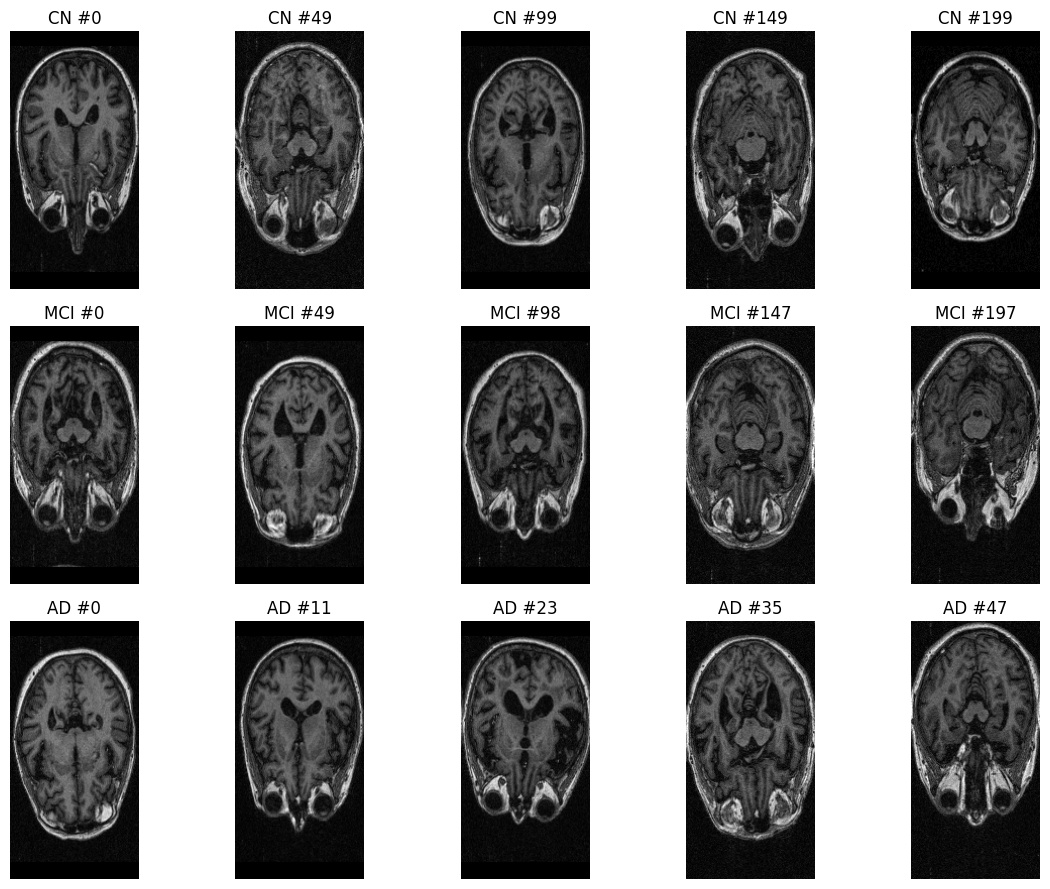

In [4]:
fig, axes = plt.subplots(len(classes), 5, figsize=(12, 3*len(classes)))
for i, c in enumerate(classes):
    if data[c] is None:
        continue
    n = min(5, data[c].shape[0])
    idx = np.linspace(0, data[c].shape[0]-1, n, dtype=int)
    for j, k in enumerate(idx):
        ax = axes[i, j] if len(classes) > 1 else axes[j]
        ax.imshow(data[c][k], cmap='gray')
        ax.set_title(f"{c} #{k}")
        ax.axis('off')
plt.tight_layout()
plt.show()

## 3. Distribución Global de Intensidades

### ¿Qué se analiza aquí?

Analizamos la **distribución de valores de intensidad** de todos los píxeles de todas las imágenes de cada clase mediante histogramas superpuestos. Esto proporciona una visión global de cómo difieren las intensidades entre categorías.

### ¿Qué buscamos encontrar?

1. **Diferencias en distribución**:
   - **Desplazamiento de la distribución**: ¿Las imágenes de AD tienen intensidades promedio diferentes?
   - **Cambios en forma**: ¿La distribución es más sesgada en alguna categoría?
   - **Diferencias en varianza**: ¿Hay más variabilidad en alguna clase?

2. **Patrones específicos**:
   - **Píxeles oscuros (0-85)**: Tejido denso, hueso, espacios vacíos
   - **Píxeles medios (85-170)**: Materia gris y blanca del cerebro
   - **Píxeles claros (170-255)**: Líquido cefalorraquídeo, ventrículos

3. **Solapamiento entre clases**:
   - **Mucho solapamiento**: Difícil distinguir clases basándose solo en intensidad global
   - **Poco solapamiento**: La intensidad global puede ser un buen discriminador

### ¿Por qué es importante?

- **Biomarcador global**: Las diferencias en distribución de intensidades pueden ser indicadores de enfermedad
- **Atrofia cerebral**: En AD, la pérdida de tejido puede cambiar la proporción de píxeles de diferentes intensidades
- **Validación de normalización**: Confirma que el preprocesamiento fue consistente entre clases
- **Base para análisis más detallados**: Proporciona contexto para análisis regionales posteriores

### Interpretación esperada:

- **CN**: Distribución balanceada, pico en intensidades medias (tejido cerebral)
- **MCI**: Distribución similar a CN pero con posibles cambios sutiles
- **AD**: 
  - Posible aumento en píxeles oscuros (espacios vacíos por atrofia)
  - Posible aumento en píxeles claros (ventrículos expandidos)
  - Posible disminución en píxeles medios (pérdida de tejido cerebral)
- **Solapamiento**: Si hay mucho solapamiento, necesitamos análisis más sofisticados (espaciales, regionales)

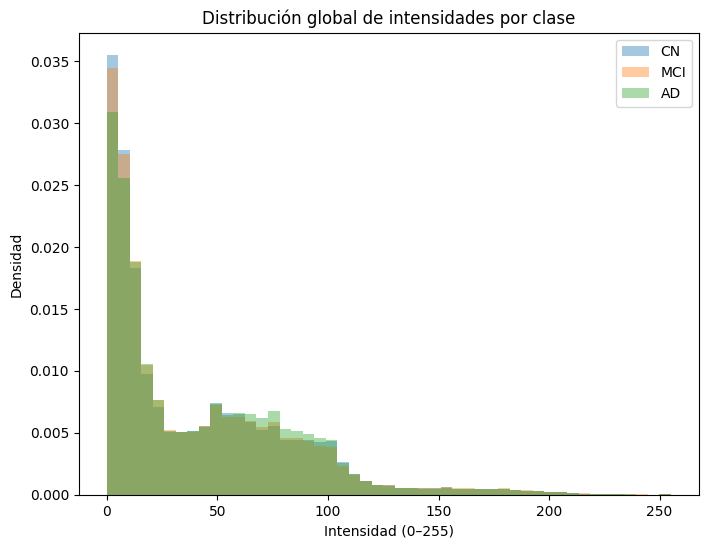

In [5]:
plt.figure(figsize=(8,6))
bins = np.linspace(0, 255, 50)
for c, color in zip(classes, ['tab:blue', 'tab:orange', 'tab:green']):
    if data[c] is None:
        continue
    vals = data[c].ravel()
    plt.hist(vals, bins=bins, alpha=0.4, label=c, density=True, color=color)

plt.xlabel('Intensidad (0–255)')
plt.ylabel('Densidad')
plt.title('Distribución global de intensidades por clase')
plt.legend()
plt.show()

## 4. Análisis por Secciones (Grilla 2D)

### ¿Qué se analiza aquí?

Dividimos cada imagen en una **grilla espacial** (por ejemplo 4×4 o 8×8) y calculamos el promedio de intensidad en cada región. Luego promediamos estos valores entre todos los sujetos de cada clase para obtener un **mapa de calor** que muestra qué regiones del corte coronal tienen diferentes intensidades entre clases.

### ¿Qué buscamos encontrar?

1. **Regiones con diferencias significativas**:
   - ¿Qué áreas del cerebro muestran más cambios entre CN, MCI y AD?
   - ¿Hay regiones específicas que son más afectadas por la enfermedad?

2. **Patrones espaciales**:
   - **Asimetrías**: ¿Los cambios son más pronunciados en un lado del cerebro?
   - **Regiones específicas**: 
     - Ventrículos laterales (regiones centrales)
     - Corteza cerebral (regiones periféricas)
     - Materia blanca vs gris

3. **Progresión de la enfermedad**:
   - ¿Las diferencias son más marcadas en AD que en MCI?
   - ¿Hay regiones que cambian tempranamente (MCI) vs tardíamente (AD)?

### ¿Por qué es importante?

- **Localización de cambios**: Identifica qué partes del cerebro están más afectadas
- **Biomarcadores regionales**: Regiones específicas pueden ser mejores discriminadores que la intensidad global
- **Comprensión anatómica**: Relaciona cambios estadísticos con anatomía cerebral
- **Guía para análisis más detallados**: Indica dónde enfocar análisis más granulares

### Parámetros importantes:

- **GRID_X, GRID_Y**: Tamaño de la grilla (ej: 4×4, 8×8)
  - **Grilla más pequeña (4×4)**: Análisis más grueso, menos detalle, más robusto estadísticamente
  - **Grilla más grande (8×8)**: Análisis más fino, más detalle, requiere más datos

### Interpretación esperada:

- **Mapas de calor diferentes**: Indica que las clases tienen patrones espaciales distintos
- **Regiones centrales más claras en AD**: Puede indicar expansión ventricular
- **Regiones periféricas más oscuras en AD**: Puede indicar atrofia cortical
- **Patrones asimétricos**: Pueden indicar afectación unilateral o artefactos

In [6]:
GRID_X, GRID_Y = 8, 8  # puedes probar 8x8 también

def grid_means(imgs, gx=8, gy=8):
    """imgs: (N, H, W) → retorna (gx, gy) con promedio por región promediado entre sujetos"""
    if imgs is None:
        return None
    N, H, W = imgs.shape
    hx, wx = H // gx, W // gy
    grid = np.zeros((gx, gy), dtype=np.float32)
    for i in range(gx):
        for j in range(gy):
            patch = imgs[:, i*hx:(i+1)*hx, j*wx:(j+1)*wx]
            grid[i,j] = patch.mean()
    return grid

grid_maps = {c: grid_means(data[c], GRID_X, GRID_Y) for c in classes}
grid_maps

{'CN': array([[ 5.85583  ,  9.246778 , 20.075302 , 26.374844 , 26.232744 ,
         22.164776 , 10.496856 ,  5.8353515],
        [19.17083  , 53.242157 , 62.64177  , 59.44286  , 58.975048 ,
         61.219345 , 52.60671  , 27.080585 ],
        [49.977676 , 56.220985 , 67.29098  , 62.809494 , 60.048683 ,
         65.38717  , 59.36541  , 54.68119  ],
        [50.418888 , 55.00385  , 68.01489  , 59.350773 , 57.76705  ,
         68.95751  , 56.92465  , 53.864853 ],
        [52.54677  , 51.00117  , 63.51406  , 58.97294  , 54.07341  ,
         64.358795 , 50.506134 , 55.523136 ],
        [23.92334  , 60.6337   , 72.1595   , 59.50286  , 55.761143 ,
         71.984406 , 63.443172 , 26.431456 ],
        [ 9.187041 , 20.01212  , 36.913486 , 37.756367 , 37.14674  ,
         39.86347  , 20.941093 ,  9.551953 ],
        [ 5.400791 ,  5.8586035,  6.234443 ,  6.665723 ,  6.483047 ,
          5.8134475,  5.5714846,  5.4820213]], dtype=float32),
 'MCI': array([[ 6.2342567, 12.239889 , 25.168068 , 30.60

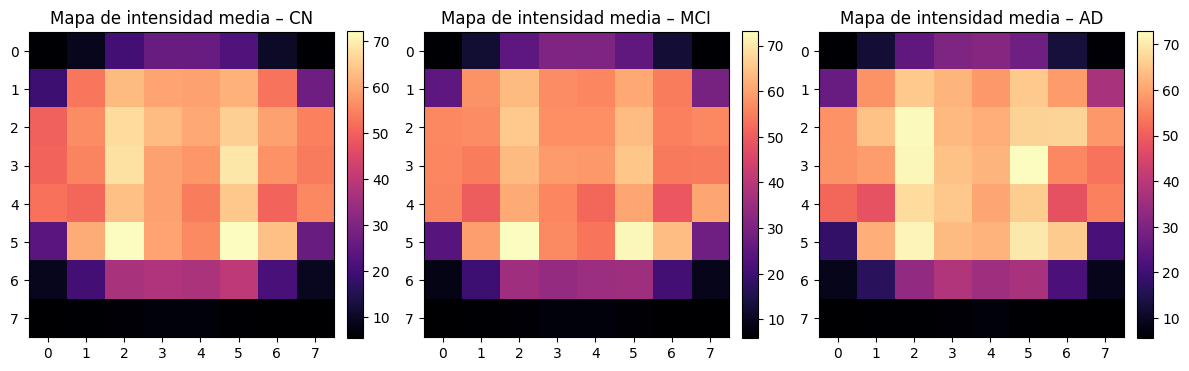

In [7]:
fig, axes = plt.subplots(1, len(classes), figsize=(4*len(classes),4))
for i, c in enumerate(classes):
    ax = axes[i] if len(classes) > 1 else axes
    gm = grid_maps[c]
    if gm is None:
        ax.axis('off')
        continue
    im = ax.imshow(gm, cmap='magma')
    ax.set_title(f'Mapa de intensidad media – {c}')
    ax.set_xticks(range(GRID_Y))
    ax.set_yticks(range(GRID_X))
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

### 4.1. Mapas de Diferencia entre Clases

### ¿Qué se analiza aquí?

Calculamos **diferencias directas** entre los mapas de intensidad promedio de diferentes clases (MCI - CN y AD - CN) para visualizar exactamente dónde y cuánto difieren las intensidades.

### ¿Qué buscamos encontrar?

1. **Magnitud de diferencias**:
   - **Valores positivos (rojos)**: Regiones donde la clase comparada tiene mayor intensidad que CN
   - **Valores negativos (azules)**: Regiones donde la clase comparada tiene menor intensidad que CN
   - **Valores cercanos a cero (blancos)**: Regiones sin diferencias significativas

2. **Localización de cambios**:
   - ¿Qué regiones específicas muestran las mayores diferencias?
   - ¿Las diferencias están concentradas en ciertas áreas o distribuidas?

3. **Progresión de la enfermedad**:
   - **MCI - CN**: Cambios tempranos, sutiles
   - **AD - CN**: Cambios avanzados, más marcados
   - Comparar ambos mapas muestra cómo progresa la enfermedad

### ¿Por qué es importante?

- **Visualización directa**: Muestra exactamente dónde están las diferencias
- **Cuantificación de cambios**: Permite medir la magnitud de las diferencias
- **Validación de hipótesis**: Confirma si los cambios esperados realmente existen
- **Guía clínica**: Puede indicar qué regiones son más importantes para diagnóstico

### Interpretación esperada:

- **Regiones centrales más claras (rojas) en AD**: Expansión ventricular (más LCR = mayor intensidad)
- **Regiones periféricas más oscuras (azules) en AD**: Atrofia cortical (menos tejido = menor intensidad)
- **Diferencias pequeñas en MCI**: Cambios sutiles, difíciles de detectar
- **Diferencias grandes en AD**: Cambios marcados, más fáciles de detectar

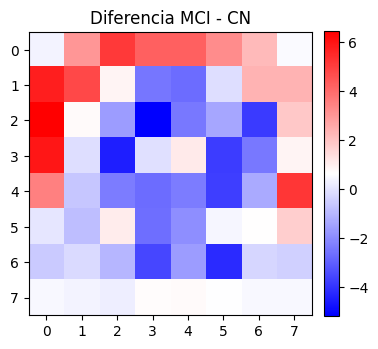

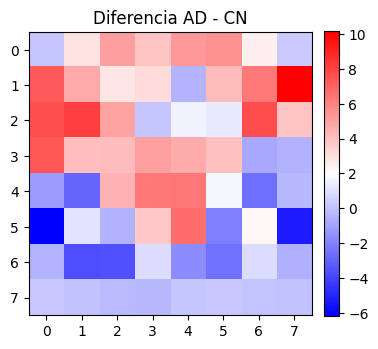

In [8]:
def plot_diff(map_a, map_b, title):
    if map_a is None or map_b is None:
        print('[WARN] Algún mapa es None, no se puede graficar diferencia')
        return
    diff = map_b - map_a
    plt.figure(figsize=(4,4))
    im = plt.imshow(diff, cmap='bwr')
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(GRID_Y))
    plt.yticks(range(GRID_X))
    plt.show()

plot_diff(grid_maps['CN'], grid_maps['MCI'], 'Diferencia MCI - CN')
plot_diff(grid_maps['CN'], grid_maps['AD'], 'Diferencia AD - CN')

## 5. Perfiles de Intensidad por Columnas y Filas

### ¿Qué se analiza aquí?

Calculamos el **promedio de intensidad** a lo largo de cada columna (eje izquierda-derecha) y cada fila (eje superior-inferior) de las imágenes, promediado entre todos los sujetos de cada clase. Esto crea **perfiles unidimensionales** que muestran cómo varía la intensidad a lo largo de diferentes direcciones del corte coronal.

### ¿Qué buscamos encontrar?

1. **Patrones direccionales**:
   - **Perfil por columnas**: Muestra variación de izquierda a derecha
     - Puede revelar asimetrías entre hemisferios
     - Puede mostrar estructuras centrales (ventrículos) vs periféricas (corteza)
   - **Perfil por filas**: Muestra variación de arriba a abajo
     - Puede revelar diferencias entre regiones superiores (corteza) e inferiores (tronco cerebral)

2. **Diferencias entre clases**:
   - ¿Los perfiles tienen formas diferentes entre CN, MCI y AD?
   - ¿En qué posiciones (columnas/filas) hay mayores diferencias?
   - ¿Hay desplazamientos o cambios de amplitud en los perfiles?

3. **Puntos de inflexión**:
   - Cambios bruscos en el perfil pueden indicar transiciones entre estructuras anatómicas
   - Comparar estos puntos entre clases puede revelar cambios estructurales

### ¿Por qué es importante?

- **Análisis direccional**: Proporciona información sobre variación espacial en direcciones específicas
- **Detección de asimetrías**: Los perfiles por columnas pueden revelar asimetrías entre hemisferios
- **Simplificación**: Reduce la complejidad 2D a análisis 1D más fáciles de interpretar
- **Biomarcadores direccionales**: Puede identificar posiciones específicas (índices de columna/fila) que son buenos discriminadores

### Interpretación esperada:

- **Perfiles por columnas**:
  - **Simétricos en CN**: Hemisferios balanceados
  - **Asimétricos en AD**: Posible afectación unilateral
  - **Pico central**: Puede indicar ventrículos (mayor intensidad = más LCR)
- **Perfiles por filas**:
  - **Variación gradual**: Transición suave entre regiones
  - **Cambios bruscos**: Transiciones entre estructuras anatómicas
  - **Diferencias en amplitud**: Puede indicar atrofia o expansión en ciertas regiones
- **Diferencias entre clases**: 
  - **Desplazamientos**: Cambios en la posición de estructuras
  - **Cambios de amplitud**: Cambios en el tamaño de estructuras
  - **Cambios de forma**: Alteraciones en la distribución espacial

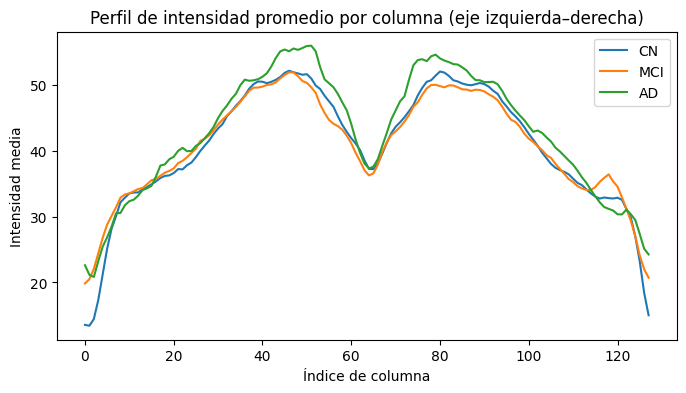

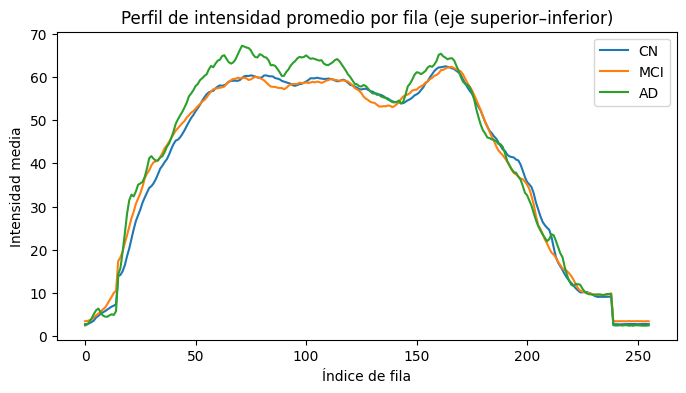

In [9]:
profiles_cols = {}
profiles_rows = {}

for c in classes:
    if data[c] is None:
        profiles_cols[c] = None
        profiles_rows[c] = None
        continue
    imgs = data[c]
    # Promediar entre sujetos primero
    mean_img = imgs.mean(axis=0)  # (H, W)
    profiles_cols[c] = mean_img.mean(axis=0)  # promedio por columna (W,)
    profiles_rows[c] = mean_img.mean(axis=1)  # promedio por fila (H,)

plt.figure(figsize=(8,4))
for c in classes:
    if profiles_cols[c] is not None:
        plt.plot(profiles_cols[c], label=c)
plt.title('Perfil de intensidad promedio por columna (eje izquierda–derecha)')
plt.xlabel('Índice de columna')
plt.ylabel('Intensidad media')
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
for c in classes:
    if profiles_rows[c] is not None:
        plt.plot(profiles_rows[c], label=c)
plt.title('Perfil de intensidad promedio por fila (eje superior–inferior)')
plt.xlabel('Índice de fila')
plt.ylabel('Intensidad media')
plt.legend()
plt.show()

## 6. Imagen Promedio por Clase y Mapas de Diferencia Voxel a Voxel

### ¿Qué se analiza aquí?

Calculamos la **imagen promedio** (promediando todos los píxeles correspondientes entre todas las imágenes de cada clase) y luego visualizamos las **diferencias directas** entre estas imágenes promedio a nivel de píxel individual (voxel a voxel).

### ¿Qué buscamos encontrar?

1. **Imágenes promedio**:
   - **Estructura típica**: Muestra cómo se ve "típicamente" un cerebro en cada categoría
   - **Patrones comunes**: Estructuras que son consistentes dentro de cada clase
   - **Variabilidad promedio**: La imagen promedio suaviza variaciones individuales

2. **Mapas de diferencia voxel a voxel**:
   - **Precisión espacial máxima**: Muestra diferencias a nivel de píxel individual
   - **Localización exacta**: Identifica exactamente qué píxeles difieren entre clases
   - **Magnitud de cambios**: Muestra cuánto difieren los valores en cada píxel

3. **Patrones de cambio**:
   - **Regiones con cambios grandes**: Áreas más afectadas por la enfermedad
   - **Regiones sin cambios**: Áreas preservadas
   - **Gradientes de cambio**: Transiciones suaves o bruscas entre regiones

### ¿Por qué es importante?

- **Visualización anatómica**: Las imágenes promedio muestran la anatomía típica de cada clase
- **Precisión espacial**: Los mapas de diferencia voxel a voxel proporcionan la máxima resolución espacial
- **Biomarcadores precisos**: Identifica exactamente qué regiones son mejores discriminadores
- **Validación visual**: Confirma que los cambios cuantitativos tienen sentido anatómico

### Comparación con análisis de grilla:

- **Análisis de grilla (Sección 4)**: Más robusto estadísticamente, menos detalle espacial
- **Análisis voxel a voxel (esta sección)**: Máximo detalle espacial, puede ser más sensible a ruido

### Interpretación esperada:

- **Imágenes promedio**:
  - **CN**: Estructura cerebral preservada, ventrículos normales
  - **MCI**: Cambios sutiles visibles
  - **AD**: Atrofia visible, ventrículos expandidos
- **Mapas de diferencia**:
  - **Regiones rojas (positivas)**: Mayor intensidad en la clase comparada (ej: ventrículos expandidos)
  - **Regiones azules (negativas)**: Menor intensidad en la clase comparada (ej: atrofia cortical)
  - **Regiones blancas**: Sin diferencias significativas
  - **Patrones coherentes**: Los cambios deberían formar patrones anatómicamente coherentes


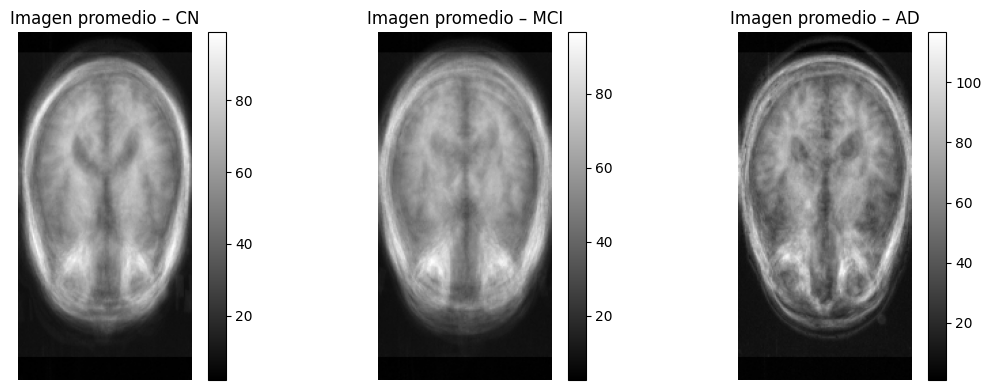

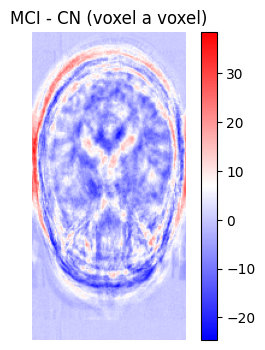

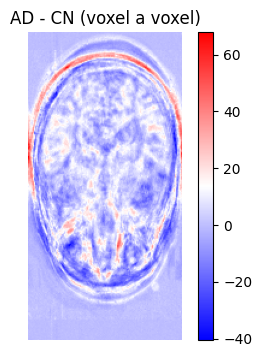

In [10]:
mean_imgs = {}
for c in classes:
    if data[c] is None:
        mean_imgs[c] = None
    else:
        mean_imgs[c] = data[c].mean(axis=0)

fig, axes = plt.subplots(1, len(classes), figsize=(4*len(classes),4))
for i, c in enumerate(classes):
    ax = axes[i] if len(classes) > 1 else axes
    if mean_imgs[c] is None:
        ax.axis('off')
        continue
    im = ax.imshow(mean_imgs[c], cmap='gray')
    ax.set_title(f'Imagen promedio – {c}')
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

def show_diff(a, b, title):
    if a is None or b is None:
        print('[WARN] No se puede mostrar diferencia, alguna clase está vacía')
        return
    diff = b - a
    plt.figure(figsize=(5,4))
    im = plt.imshow(diff, cmap='bwr')
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.axis('off')
    plt.show()

show_diff(mean_imgs['CN'], mean_imgs['MCI'], 'MCI - CN (voxel a voxel)')
show_diff(mean_imgs['CN'], mean_imgs['AD'], 'AD - CN (voxel a voxel)')

## 7. Análisis de Componentes Principales (PCA) Espacial

### ¿Qué se analiza aquí?

Aplicamos **Análisis de Componentes Principales (PCA)** sobre las imágenes aplanadas (cada imagen se convierte en un vector de píxeles) para reducir la dimensionalidad y visualizar si las imágenes se agrupan por clase en el espacio de características reducido.

### ¿Qué buscamos encontrar?

1. **Separabilidad de clases**:
   - ¿Las imágenes de diferentes clases se agrupan en regiones distintas del espacio PCA?
   - ¿Hay solapamiento entre clases en el espacio 2D de las primeras dos componentes?
   - ¿Qué tan bien separadas están las clases?

2. **Componentes principales**:
   - **PC1 y PC2**: Las dos primeras componentes principales capturan la mayor variabilidad
   - Si las clases están bien separadas en PC1/PC2, estas componentes capturan información relevante para la clasificación

3. **Estructura de los datos**:
   - **Clusters**: Grupos naturales de imágenes similares
   - **Outliers**: Imágenes que no se ajustan a los patrones típicos de su clase
   - **Variabilidad**: Cómo se distribuyen las imágenes dentro de cada clase

### ¿Por qué es importante?

- **Reducción de dimensionalidad**: De ~32,000 píxeles a 2 dimensiones para visualización
- **Evaluación de separabilidad**: Si las clases no se separan en PCA, puede ser difícil clasificarlas
- **Detección de estructura**: Revela si hay patrones subyacentes en los datos
- **Guía para modelado**: Si hay buena separación, modelos lineales pueden funcionar bien

### Limitaciones:

- **Solo 2 componentes**: Visualizamos solo las 2 primeras componentes, puede haber información importante en componentes superiores
- **Linealidad**: PCA es una transformación lineal, puede no capturar relaciones no lineales
- **Interpretabilidad**: Las componentes principales son combinaciones lineales de píxeles, no tienen interpretación anatómica directa

### Interpretación esperada:

- **Buenas separación**: 
  - Clusters distintos para cada clase
  - Poco solapamiento entre clases
  - Indica que hay información suficiente para clasificación
- **Separación parcial**:
  - Algún solapamiento entre clases
  - Puede requerir modelos no lineales o más características
- **Poca separación**:
  - Mucho solapamiento
  - Puede indicar que las diferencias son muy sutiles o que se necesita más información
- **Outliers**:
  - Puntos alejados de su cluster
  - Pueden ser casos atípicos o errores de etiquetado

X shape: (446, 32768)


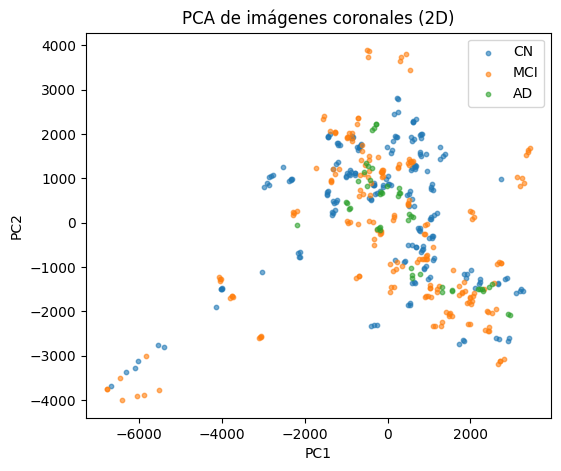

In [11]:
# Construimos un dataset combinado para PCA
X = []
y = []
for c in classes:
    if data[c] is None:
        continue
    imgs = data[c]
    n, h, w = imgs.shape
    X.append(imgs.reshape(n, h*w))
    y += [c]*n

if len(X) > 0:
    X = np.vstack(X)
    print('X shape:', X.shape)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(6,5))
    for c, color in zip(classes, ['tab:blue', 'tab:orange', 'tab:green']):
        idxs = [i for i, label in enumerate(y) if label == c]
        if not idxs:
            continue
        plt.scatter(X_pca[idxs,0], X_pca[idxs,1], s=10, alpha=0.6, label=c, c=color)
    plt.title('PCA de imágenes coronales (2D)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.show()
else:
    print('[WARN] No hay datos suficientes para PCA')